In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.special import expit
from experiment_constant import *

/home/sergei/miniconda3/envs/ML/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
W1 = np.ones((4, 3))
W2 = np.ones((3, 2))
W3 = np.ones((2, 5))
B1 = np.ones((3, 1))
B2 = np.ones((2, 1))
B3 = np.ones((5, 1))
K = 0.123
p = 0.321
experiment = ConstantExperiment([4, 3, 2, 1], p, K, [W1, W2, W3], [B1, B2, B3], do_print = True)

mean_bound, std_bound = experiment.get_mean_std_error()
print(mean_bound, std_bound)

Creating network for 4-dimensional input and 1-dimensional output, with 2 hidden layers
0.802853742 1.00294354442138


First layer: 4 input neurons, each having value of 1. Therefore the input is $4$. Maximal output is $1$, output on ones is $\sigma(4Kx)=\sigma(16)$. These three neurons fail with probability $p=0.1$.

The second level consisting of two neurons receives input error $\xi\sim Bin(3, p)$

The third and final level receives input error $\eta_1+(1-\eta_1)K\xi+\eta_2+(1-\eta_2)K\eta$

Therefore $\mathbb{E}\Delta=2p+2(1-p)K3p$

And $\Delta^2=\eta_1^2+(1-\eta_1)^2K^2\xi^2+\eta_2^2+(1-\eta_2)^2K^2\eta^2+\eta_1(1-\eta_1)K\xi+\eta_2(1-\eta_2)K\xi+\eta_1(1-\eta_2)K\xi+\eta_2(1-\eta_1)K\xi+\eta_1\eta_2+(1-\eta_1)(1-\eta_2)K^2\xi^2$

In [3]:
Exi2=(3*p+6*p**2)*K**2
assert np.allclose(2*p+2*(1-p)*K*3*p, mean_bound), "Mean"
assert np.allclose(2*p+2*(1-p)*Exi2+2*p**2+4*p*(1-p)*3*p*K+2*(1-p)**2*Exi2, std_bound ** 2), "Std"

Mean error 0.63784, 79.45% from theoretical, norm 0.79
Mean error 0.64933, 80.88% from theoretical, norm 0.83
Mean error 0.64783, 80.69% from theoretical, norm 0.88
Mean error 0.65474, 81.55% from theoretical, norm 0.98
Mean error 0.65477, 81.56% from theoretical, norm 1.10
Mean error 0.65940, 82.13% from theoretical, norm 1.08
Mean error 0.65890, 82.07% from theoretical, norm 1.10
Mean error 0.65822, 81.99% from theoretical, norm 1.14
Mean error 0.66987, 83.44% from theoretical, norm 1.27
Mean error 0.65862, 82.03% from theoretical, norm 1.35
Mean error 0.66153, 82.40% from theoretical, norm 1.42
Mean error 0.65800, 81.96% from theoretical, norm 1.45
Mean error 0.66714, 83.10% from theoretical, norm 1.46
Mean error 0.66294, 82.57% from theoretical, norm 1.45
Mean error 0.66398, 82.70% from theoretical, norm 1.40
Mean error 0.66221, 82.48% from theoretical, norm 1.43
Mean error 0.66374, 82.67% from theoretical, norm 1.47
Mean error 0.67229, 83.74% from theoretical, norm 1.62
Mean error

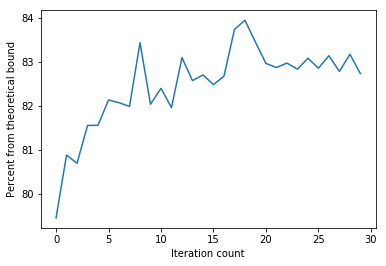

In [4]:
# Trying genetic search for x
np.random.seed(42)

# Setting parameters and creating the experiment
N = 4
repetitions = 10000
to_add = 10
to_keep = 5

# creating initial inputs
data = np.random.randn(to_keep, N)

# percents from theoretical bound
percents = []

maxiter = 30

for _ in range(maxiter):
  data_ = data

  # Randomizing inputs
  for input_ in data_:
    rand_direction = np.random.randn(to_add, N)
    rand_direction /= np.linalg.norm(rand_direction, axis = 0)
    rand_direction *= 0.5
    input_ = input_ + rand_direction
    data = np.vstack((data, input_))

  # Computing true values
  trues = [experiment.predict_no_dropout(value) for value in data]

  # Running the experiment
  errors = [experiment.get_error(value, repetitions = repetitions) for value in data]

  # List of errors for inputs
  error_array = np.mean(np.max(np.abs(errors), axis = 2), axis = 1)

  max_exp = np.max(error_array)
  
  # Choosing maximal error
  indices = np.argsort(-error_array)

  # Choosing best to_keep entries
  data = data[indices[:to_keep]]
  
  percent = 100 * max_exp / mean_bound
  print('Mean error %.5f, %.2f%% from theoretical, norm %.2f' % (max_exp, percent, np.linalg.norm(data.flatten()) / data.shape[0]))
  percents.append(percent)
  
plt.xlabel('Iteration count')
plt.ylabel('Percent from theoretical bound')
plt.plot(percents)
plt.show()

In [5]:
# Trying genetic search for x
np.random.seed(42)

mean_bound, std_bound = experiment.get_mean_std_error()

# creating initial inputs
data = np.random.randn(to_keep, N)

# percents from theoretical bound
percents_mean = []
percents_std = []

maxiter = 30

for _ in range(maxiter):
  data_ = data

  # Randomizing inputs
  for input_ in data_:
    rand_direction = np.random.randn(to_add, N)
    rand_direction /= np.linalg.norm(rand_direction, axis = 0)
    rand_direction *= 0.5
    input_ = input_ + rand_direction
    data = np.vstack((data, input_))

  # Computing true values
  trues = [experiment.predict_no_dropout(value) for value in data]

  # Running the experiment
  errors = [experiment.get_error(value, repetitions = repetitions) for value in data]

  # List of errors for inputs
  error_std_array  = np.std(np.max(np.abs(errors), axis = 2), axis = 1)
  error_mean_array = np.mean(np.max(np.abs(errors), axis = 2), axis = 1)

  max_std_exp = np.max(error_std_array)
  max_mean_exp = np.max(error_mean_array)
  
  # Choosing maximal error
  indices = np.argsort(-error_std_array)

  # Choosing best to_keep entries
  data = data[indices[:to_keep]]
  
  percent_mean = 100 * max_mean_exp / mean_bound
  percent_std = 100 * max_std_exp / std_bound
  print('Mean error %.5f, %.2f%% from theoretical, Std error %.5f, %.2f%% from theoretical, norm %.2f' % (
      max_mean_exp, percent_mean, max_std_exp, percent_std, np.linalg.norm(data.flatten()) / data.shape[0]))
  percents_mean.append(percent_mean)
  percents_std.append(percent_std)

Mean error 0.63547, 79.15% from theoretical, Std error 0.53156, 53.00% from theoretical, norm 0.78
Mean error 0.64819, 80.74% from theoretical, Std error 0.53499, 53.34% from theoretical, norm 0.84
Mean error 0.65003, 80.97% from theoretical, Std error 0.53758, 53.60% from theoretical, norm 0.89
Mean error 0.64958, 80.91% from theoretical, Std error 0.53861, 53.70% from theoretical, norm 0.99
Mean error 0.65428, 81.49% from theoretical, Std error 0.53988, 53.83% from theoretical, norm 1.04
Mean error 0.65367, 81.42% from theoretical, Std error 0.54016, 53.86% from theoretical, norm 1.15
Mean error 0.66030, 82.24% from theoretical, Std error 0.54490, 54.33% from theoretical, norm 1.22
Mean error 0.65929, 82.12% from theoretical, Std error 0.54421, 54.26% from theoretical, norm 1.30
Mean error 0.66177, 82.43% from theoretical, Std error 0.54640, 54.48% from theoretical, norm 1.39
Mean error 0.66341, 82.63% from theoretical, Std error 0.55141, 54.98% from theoretical, norm 1.46
Mean error

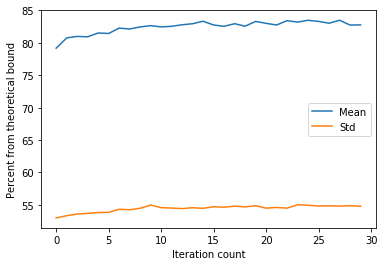

In [6]:
plt.xlabel('Iteration count')
plt.ylabel('Percent from theoretical bound')
plt.plot(percents_mean, label='Mean')
plt.plot(percents_std, label='Std')
plt.legend()
plt.show()

In [7]:
(std_bound ** 2 - mean_bound ** 2) ** 0.5 / std_bound

0.5993361702749445

In [ ]:
# why 104 instead of 100 and 92 instead of 90?